<a href="https://colab.research.google.com/github/cloudynirvana/TNBC-Metabolic-Strain-MOD/blob/main/tnbc_ode_bifurcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-2-28f5dd8ba6d1>:64: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_c = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))


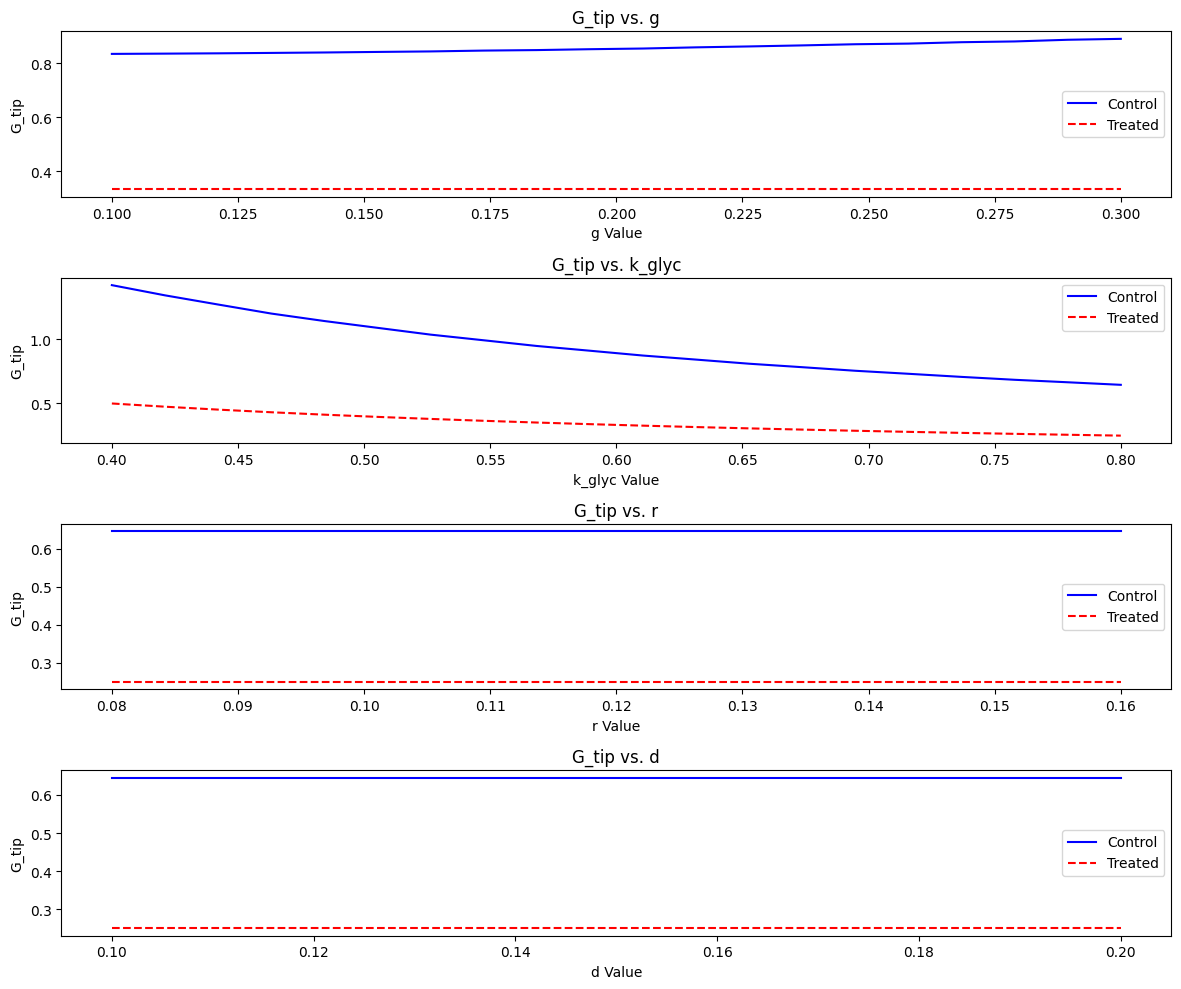

In [ ]:
# Cell: Holistic Bifurcation Analysis
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define initial conditions and time points (assumed from earlier cells)
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Define the ODE system (assumed from earlier cells)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Define G_tip function (assumed from earlier cells)
def find_G_tip(sol):
    A, _, G_lc = sol.T
    idx = np.where(A < 2.0)[0]
    return G_lc[idx[0]] if len(idx) > 0 else G_lc[-1]

# Sweep key parameters
params_to_sweep = {
    'g': np.linspace(0.1, 0.3, 20),      # ROS generation
    'k_glyc': np.linspace(0.4, 0.8, 20), # Glycolysis rate
    'r': np.linspace(0.08, 0.16, 20),    # Drug efficacy
    'd': np.linspace(0.1, 0.2, 20)       # ROS degradation
}
results = {key: {'control': [], 'treated': []} for key in params_to_sweep}

# Initialize params_control and params_treated with all required parameters
params_control = {
    'k_glyc': 0.6,    # Glycolysis rate (mM/min)
    'u': 0.5,         # Glucose uptake (mM/min)
    's': 0.15,        # ATP sensitivity to ROS
    'g': 0.2,         # ROS generation factor
    'h': 0.01,        # ROS autocatalysis
    'r': 0.1,         # Baseline efficacy
    'i_glyc': 0.3,    # Glycolysis inhibition by DOX
    'd': 0.15,        # ROS degradation rate
    'Nano_DOX': 0,    # No doxorubicin in control
    'Nano_ROS': 0     # No ROS modulation in control
}
params_treated = {
    'k_glyc': 0.6,
    'u': 0.5,
    's': 0.15,
    'g': 0.2,
    'h': 0.01,
    'r': 0.14,        # Enhanced efficacy with treatment
    'i_glyc': 0.3,
    'd': 0.15,
    'Nano_DOX': 1,    # Doxorubicin unit dose
    'Nano_ROS': 2     # Phytochemical ROS modulation
}

# Perform bifurcation analysis
for param, values in params_to_sweep.items():
    for val in values:
        params_control[param] = val
        params_treated[param] = val
        sol_c = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
        sol_t = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
        results[param]['control'].append(find_G_tip(sol_c))
        results[param]['treated'].append(find_G_tip(sol_t))

# Plot results
plt.figure(figsize=(12, 10))
for i, (param, data) in enumerate(results.items(), 1):
    plt.subplot(4, 1, i)
    plt.plot(params_to_sweep[param], data['control'], 'b-', label='Control')
    plt.plot(params_to_sweep[param], data['treated'], 'r--', label='Treated')
    plt.xlabel(f'{param} Value')
    plt.ylabel('G_tip')
    plt.title(f'G_tip vs. {param}')
    plt.legend()
plt.tight_layout()
plt.savefig('multi_bifurcation.png', dpi=300)
plt.show()

<ipython-input-3-be8013c84783>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_c = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))


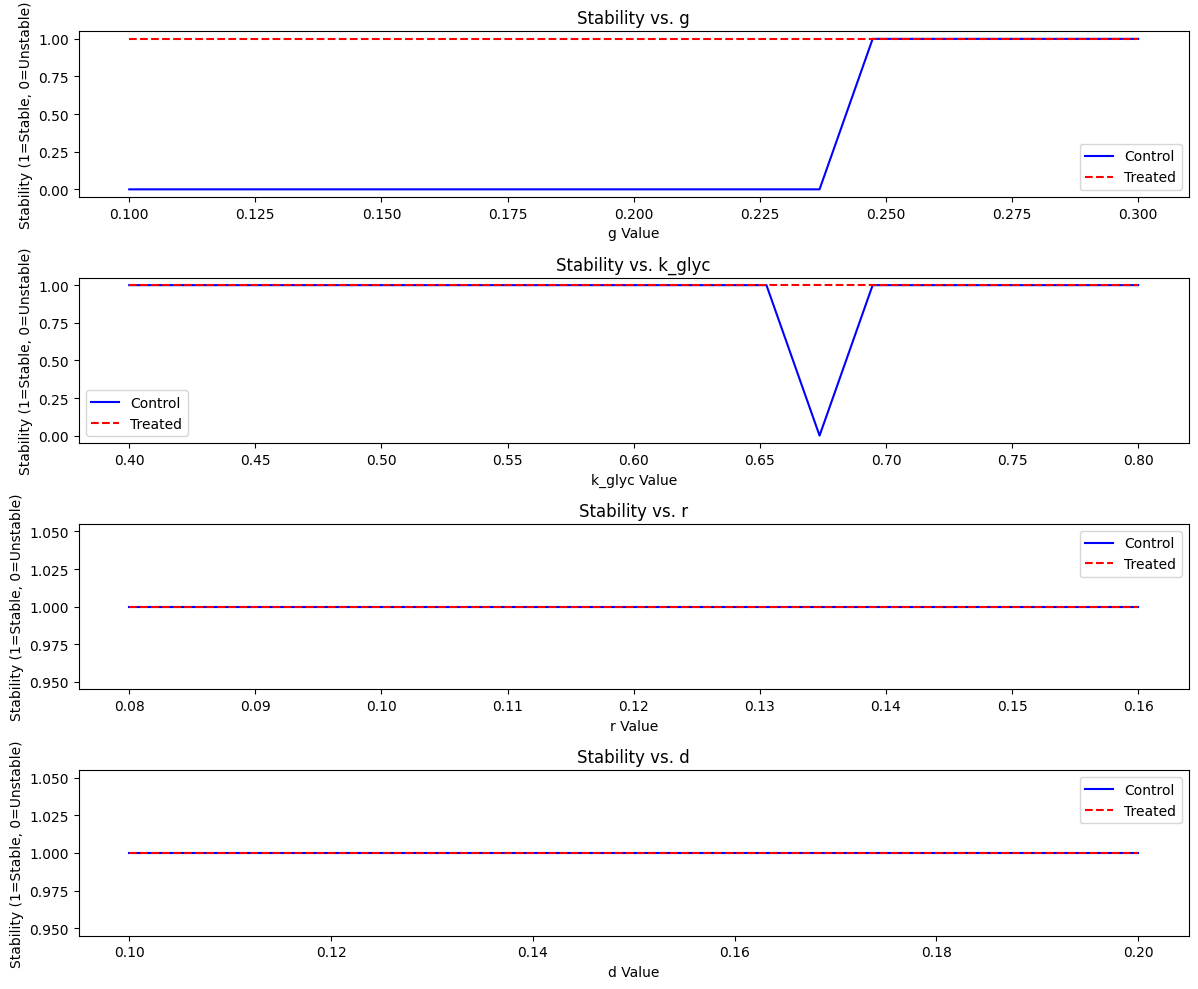

In [ ]:
# Cell: Stability Analysis
def is_stable(sol):
    A = sol[:, 0]  # ATP over time
    return 'Stable' if A[-1] > 2.0 else 'Unstable'  # End-state above collapse threshold

stability_results = {param: {'control': [], 'treated': []} for param in params_to_sweep}
for param, values in params_to_sweep.items():
    for val in values:
        params_control[param] = val
        params_treated[param] = val
        sol_c = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
        sol_t = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
        stability_results[param]['control'].append(is_stable(sol_c))
        stability_results[param]['treated'].append(is_stable(sol_t))

# Plot stability
plt.figure(figsize=(12, 10))
for i, (param, data) in enumerate(stability_results.items(), 1):
    plt.subplot(4, 1, i)
    plt.plot(params_to_sweep[param], [1 if s == 'Stable' else 0 for s in data['control']], 'b-', label='Control')
    plt.plot(params_to_sweep[param], [1 if s == 'Stable' else 0 for s in data['treated']], 'r--', label='Treated')
    plt.xlabel(f'{param} Value')
    plt.ylabel('Stability (1=Stable, 0=Unstable)')
    plt.title(f'Stability vs. {param}')
    plt.legend()
plt.tight_layout()
plt.savefig('stability_analysis.png', dpi=300)
plt.show()

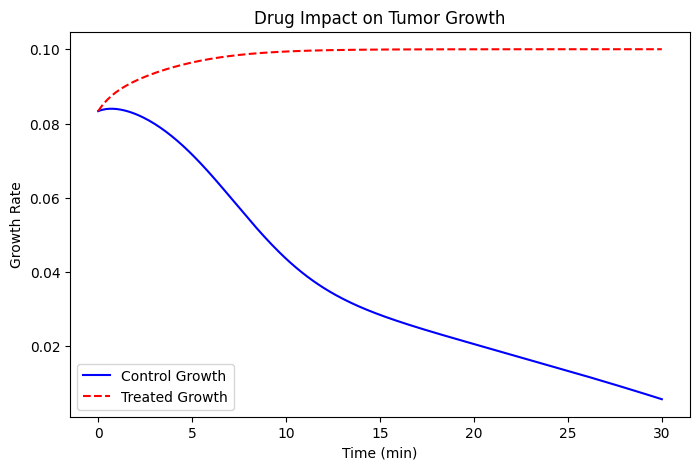

Avg Growth - Control: 0.037, Treated: 0.098


In [2]:
# Cell: Drug Design Metrics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define parameters and initial conditions (if not already defined in prior cells)
params_control = {
    'k_glyc': 0.6, 'u': 0.5, 's': 0.15, 'g': 0.2, 'h': 0.01,
    'r': 0.1, 'i_glyc': 0.3, 'd': 0.15, 'Nano_DOX': 0, 'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.6, 'u': 0.5, 's': 0.15, 'g': 0.2, 'h': 0.01,
    'r': 0.14, 'i_glyc': 0.3, 'd': 0.15, 'Nano_DOX': 1, 'Nano_ROS': 2
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Define ODE system (if not already defined)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Compute solutions (required data inputs)
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# Extract ATP for growth analysis
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Define growth rate function
def growth_rate(A, k_growth=0.1, K_m=2.0):
    return k_growth * A / (A + K_m)

# Calculate growth rates
growth_control = [growth_rate(A) for A in A_control]
growth_treated = [growth_rate(A) for A in A_treated]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(t, growth_control, 'b-', label='Control Growth')
plt.plot(t, growth_treated, 'r--', label='Treated Growth')
plt.xlabel('Time (min)')
plt.ylabel('Growth Rate')
plt.title('Drug Impact on Tumor Growth')
plt.legend()
plt.savefig('growth_plot.png', dpi=300)
plt.show()

# Print average growth rates
print(f"Avg Growth - Control: {np.mean(growth_control):.3f}, Treated: {np.mean(growth_treated):.3f}")

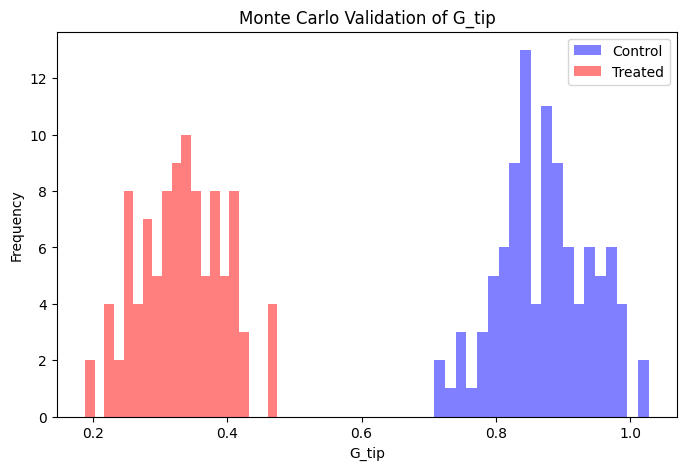

In [4]:
# Cell: Monte Carlo Validation
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define ODE system
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Define G_tip function
def find_G_tip(sol):
    A, _, G_lc = sol.T
    idx = np.where(A < 2.0)[0]
    return G_lc[idx[0]] if len(idx) > 0 else G_lc[-1]

# Define parameters and initial conditions
params_control = {
    'k_glyc': 0.6, 'u': 0.5, 's': 0.15, 'g': 0.2, 'h': 0.01,
    'r': 0.1, 'i_glyc': 0.3, 'd': 0.15, 'Nano_DOX': 0, 'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.6, 'u': 0.5, 's': 0.15, 'g': 0.2, 'h': 0.01,
    'r': 0.14, 'i_glyc': 0.3, 'd': 0.15, 'Nano_DOX': 1, 'Nano_ROS': 2
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Monte Carlo simulation
n_simulations = 100
G_tip_control_mc = []
G_tip_treated_mc = []
for _ in range(n_simulations):
    noisy_params_c = {k: v * np.random.uniform(0.9, 1.1) for k, v in params_control.items()}
    noisy_params_t = {k: v * np.random.uniform(0.9, 1.1) for k, v in params_treated.items()}
    sol_c = odeint(tnbc_system, y0, t, args=tuple(noisy_params_c.values()))
    sol_t = odeint(tnbc_system, y0, t, args=tuple(noisy_params_t.values()))
    G_tip_control_mc.append(find_G_tip(sol_c))
    G_tip_treated_mc.append(find_G_tip(sol_t))

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(G_tip_control_mc, bins=20, alpha=0.5, label='Control', color='blue')
plt.hist(G_tip_treated_mc, bins=20, alpha=0.5, label='Treated', color='red')
plt.xlabel('G_tip')
plt.ylabel('Frequency')
plt.title('Monte Carlo Validation of G_tip')
plt.legend()
plt.savefig('monte_carlo.png', dpi=300)
plt.show()